<a href="https://colab.research.google.com/github/ajankowi/Praca_inz/blob/master/Siec/Zlaczone_siec_4_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [2]:
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from keras.layers import Flatten, add, Dense, Dropout 
from keras.callbacks import ModelCheckpoint, EarlyStopping


print("TensorFlow version:", tf.__version__)
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.9.2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import csv
import random

import cv2
import imutils
import glob
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
#Określenie ścieżek do plików
zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Baza_zdjec_zlaczone_2.zip'
nazwa_CSV = 'nowe.csv'
folder = '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/'
folder_aktorzy = '/content/drive/MyDrive/Sieci/Baza_aktorzy_zlaczone/'
aktorzy_CSV = 'aktorzy.csv'
slesh = '/'
png = '.png'

In [6]:
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Baza_zdjec_zlaczone_2.zip' -d '/content/zdjecia/'
#!unzip '/content/drive/MyDrive/Sieci/Baza_aktorzy_zlaczone/Baza_aktorzy_zlaczone.zip' -d '/content/aktorzy/'

In [7]:
def release_list(a):
    
    del a[:]
    del a

In [8]:
#Wczytanie pliku CSV do tablicy images

with open(folder+nazwa_CSV,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value = []
for i in new[0]:
    value.append(int(i))    
    
print(len(value))

25200


In [9]:
#Wczytanie zdjęć do tablicy images
images = []
size = len(value)

for i in range(size):
    im = Image.open('/content/zdjecia/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images.append(arr_im) 
print(len(images))

25200


In [10]:
#Inicjalizacja tablic
rand_list = []
rand_list = np.zeros((len(images)), dtype=np.uint8)

x_test = []
y_test = []

x_train = []
y_train = []


#Okreslanie wielkosci zbiorów
nighty = int(len(images)*90/100)
ten = len(images) - nighty

#Losowanie zbioru testowego
for i in range(nighty):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images)-1)
    
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_train.append(images[rand])
    y_train.append(value[rand])
    rand_list[rand] = 1

#Losowanie zbioru uczącego
for j in range(ten):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images)-1)
        
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_test.append(images[rand])
    y_test.append(value[rand])
    rand_list[rand] = 1
    
    
release_list(images)
release_list(value)

In [11]:
#Sprawdzenie poprawności losowania
val_1 = 100 * sum(y_test) / (size / 2)
print("%.2f" % val_1 + '%') 


val_2 = 100 * sum(y_train) / (size / 2)
print("%.2f" % val_2 + '%') 




10.12%
89.88%


In [12]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.004 ... 0.024 0.004 0.   ]
 ...
 [0.    0.    0.004 ... 0.027 0.    0.   ]
 [0.    0.    0.    ... 0.008 0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]
1


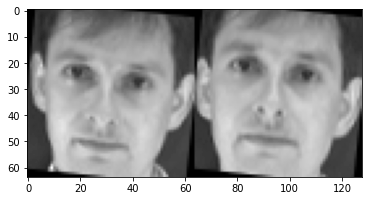

In [13]:
plt.imshow(x_train[0],cmap = 'gray')
print(x_train[0])
print(y_train[0])

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 128, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='relu'))


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 124, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 62, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 58, 64)        36928     
                                                        

In [16]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy','mse'])

#Funcka umożliwia zatrzymanie się uczenia 
#gdy wartość strat przstanie maleć
EarlyStop = EarlyStopping(monitor='val_loss',  
                          verbose=1, 
                          patience=5)


ModelCheck = ModelCheckpoint(filepath='/content/drive/MyDrive/Sieci/Zlaczone.h5',
                             monitor='val_loss',
                             save_best_only=True)


history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=100,
                    batch_size=256,
                    validation_split=0.1,
                    callbacks = [EarlyStop, ModelCheck]
                   )

Epoch 1/100
80/80 [==============================] - 123s 1s/step - loss: 0.2466 - accuracy: 0.5624 - mse: 0.2466 - val_loss: 0.2065 - val_accuracy: 0.6459 - val_mse: 0.2065
Epoch 2/100
80/80 [==============================] - 106s 1s/step - loss: 0.1808 - accuracy: 0.7194 - mse: 0.1808 - val_loss: 0.1530 - val_accuracy: 0.7941 - val_mse: 0.1530
Epoch 3/100
80/80 [==============================] - 105s 1s/step - loss: 0.1233 - accuracy: 0.8401 - mse: 0.1233 - val_loss: 0.0797 - val_accuracy: 0.9083 - val_mse: 0.0797
Epoch 4/100
80/80 [==============================] - 105s 1s/step - loss: 0.0621 - accuracy: 0.9328 - mse: 0.0621 - val_loss: 0.0466 - val_accuracy: 0.9594 - val_mse: 0.0466
Epoch 5/100
80/80 [==============================] - 105s 1s/step - loss: 0.0364 - accuracy: 0.9676 - mse: 0.0364 - val_loss: 0.0348 - val_accuracy: 0.9802 - val_mse: 0.0348
Epoch 6/100
80/80 [==============================] - 105s 1s/step - loss: 0.0262 - accuracy: 0.9796 - mse: 0.0262 - val_loss: 0.02

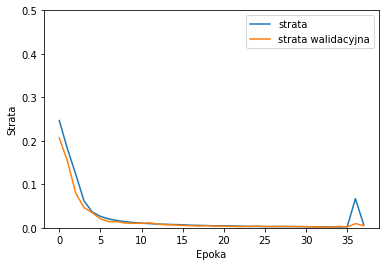

In [17]:
plt.plot(history.history['loss'], label='strata')
plt.plot(history.history['val_loss'], label = 'strata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.ylim([0.0, 0.5])
plt.legend(loc='upper right')

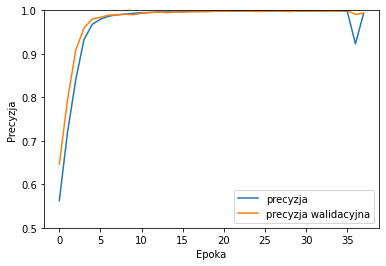

In [18]:
plt.plot(history.history['accuracy'], label='precyzja')
plt.plot(history.history['val_accuracy'], label = 'precyzja walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Precyzja')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [19]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Sieci/Zlaczone.h5')


In [20]:
best_model.evaluate(x_test,  y_test, verbose=2)

79/79 - 5s - loss: 0.0012 - accuracy: 0.9996 - mse: 0.0012 - 5s/epoch - 68ms/step


[0.0011856788900864064, 0.9996031746031746, 0.0011856788900864064]

In [21]:
predict_x = best_model.predict(x_test) 

predictions = (predict_x > 0.5).astype("int32")

79/79 [==============================] - 4s 53ms/step


In [22]:
names = [['Tn','Nn'],['Np', 'Tp']]
names = np.reshape(names,(2,2))
print(names)

names = tf.math.confusion_matrix(y_test,predictions)

[['Tn' 'Nn']
 ['Np' 'Tp']]


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1244,    1],
       [   0, 1275]], dtype=int32)>

In [23]:

#################################
#                               #
#    Wczytanie zdjęć aktorów    #
#                               #
#################################

In [24]:
with open(folder_aktorzy+aktorzy_CSV,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()


tmp = []
actors_label = []

for i in lines:
    tmp.append(i.split(" "))

#Tablica przechowująca etykiety aktorów   
act_label = []
for i in tmp[0]:
    actors_label.append(int(i))    
    
print(len(actors_label))

2052


In [25]:
#Wczytanie zdjęć aktorów do tablicy

actors_img = []
size = len(actors_label)

for i in range(size):
    im = Image.open('/content/aktorzy/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    actors_img.append(arr_im) 
print(len(actors_img))


2052


[[0.984 0.984 0.984 ... 0.192 0.196 0.196]
 [0.984 0.984 0.98  ... 0.2   0.192 0.192]
 [0.984 0.98  0.976 ... 0.204 0.196 0.192]
 ...
 [0.98  0.98  0.98  ... 0.298 0.294 0.29 ]
 [0.98  0.98  0.98  ... 0.294 0.298 0.302]
 [0.98  0.98  0.98  ... 0.298 0.31  0.302]]


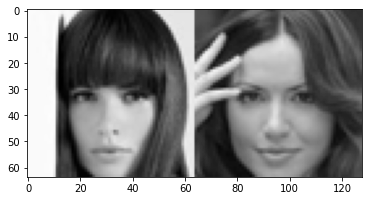

In [26]:
actors_label = np.array(actors_label)
actors_img= np.array(actors_img)
plt.imshow(actors_img[0],cmap = 'gray')
print(actors_img[0])

In [27]:
best_model.evaluate(actors_img, actors_label, verbose=2)

65/65 - 4s - loss: 0.4848 - accuracy: 0.4288 - mse: 0.4848 - 4s/epoch - 55ms/step


[0.484803090217225, 0.42884990253411304, 0.484803090217225]

In [28]:
#Testowanie sieci z wykorzystaniem zdjęć aktorów 

predict_actors = best_model.predict(actors_img) 

print(predict_actors)
predict = (predict_actors > 0.5).astype("int32")

65/65 [==============================] - 3s 53ms/step
[[0.375]
 [0.58 ]
 [0.629]
 ...
 [0.848]
 [0.798]
 [0.   ]]


In [29]:
print(names)

tf.math.confusion_matrix(actors_label,predict)

[['Tn' 'Nn']
 ['Np' 'Tp']]


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[397, 629],
       [543, 483]], dtype=int32)>